Regression model - WINE QUALITY dataset

Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Načtení zdrojového souboru

In [2]:
df = pd.read_csv("winequality-red.csv")

Dataframe information / Descriptive statistics

In [3]:
df.info()
describe_df = df.describe().T
print(describe_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
                       count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.

Use ydata_profiling for Exploratory Data Analysis, generating html report with data profile and histograms (python code and html reports in GitHub folder "Project - Regression - Wine quality")

Cleaning data - replacing null values with mean values, dropping duplicate rows

In [4]:
# Delete rows where 'citric acid' column is 0.0
df = df.loc[df['citric acid'] != 0.0].copy()

# Remove duplicates when whole row is the same, reindex DataFrame
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)


Z-score for handling outliers

In [5]:
# Calculate z-scores for each column
z_scores = np.abs((df - df.mean()) / df.std())

# Set threshold for z-scores (e.g., 4 standard deviations from the mean)
threshold = 4

# Remove outliers, reindex DataFrame
df_clean = df[(z_scores < threshold).all(axis=1)]
df_clean.reset_index(drop=True, inplace=True)

# Verify the number of rows before and after
print("Original dataset rows:", df.shape[0])
print("Dataset rows after removing outliers:", df_clean.shape[0])

# Save the cleaned dataset
df_clean.to_csv("cleaned_dataset_no_outliers.csv", index=False)
# Print the updated DataFrame
print(df_clean)

Original dataset rows: 1241
Dataset rows after removing outliers: 1192
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.8             0.760         0.04             2.3      0.092   
1              11.2             0.280         0.56             1.9      0.075   
2               7.9             0.600         0.06             1.6      0.069   
3               7.8             0.580         0.02             2.0      0.073   
4               7.5             0.500         0.36             6.1      0.071   
...             ...               ...          ...             ...        ...   
1187            6.8             0.620         0.08             1.9      0.068   
1188            6.2             0.600         0.08             2.0      0.090   
1189            5.9             0.550         0.10             2.2      0.062   
1190            5.9             0.645         0.12             2.0      0.075   
1191            6.0             0.310 

Loading clean dataset (without nulls, duplications and outliers)

In [7]:
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"])

Creating additional visualizations to familiarize with data - Pairplot and Heatmap

In [8]:
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"])

warnings.filterwarnings("ignore")

# Create the pair plot
sns.pairplot(df, hue="quality")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

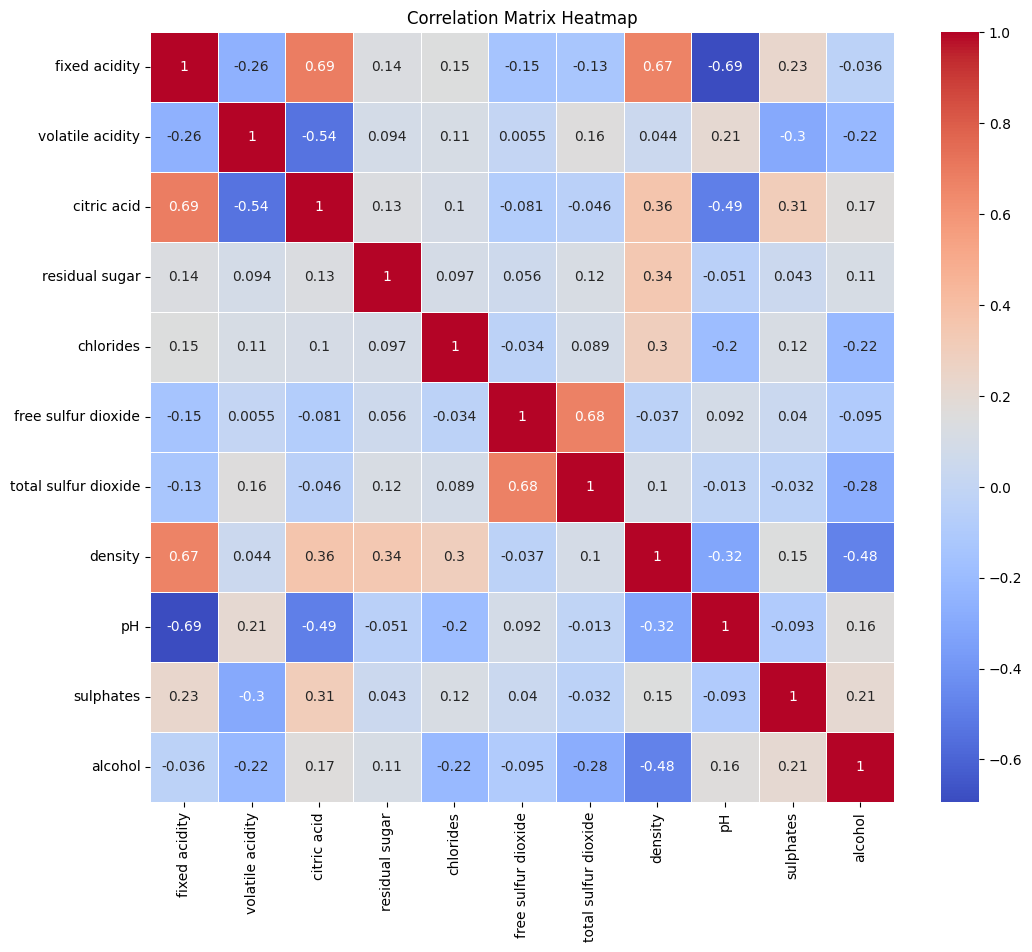

In [9]:
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"])

corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

Feature engineering

In [10]:
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop("quality", axis=1))
X = pd.DataFrame(X_scaled, columns=df.columns[:-1])
y = df["quality"]

# Feature selection using correlation
corr = df.corr()
print(corr["quality"].sort_values(ascending=False))


quality                 1.000000
alcohol                 0.510137
sulphates               0.344839
citric acid             0.237479
fixed acidity           0.124447
residual sugar          0.013064
pH                     -0.054335
free sulfur dioxide    -0.077777
chlorides              -0.141293
density                -0.193693
total sulfur dioxide   -0.245120
volatile acidity       -0.386608
Name: quality, dtype: float64


Linear regression

In [11]:
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"])

# "quality" is the name of the column we want to predict
X = df.drop("quality", axis=1)
y = df["quality"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred_linear = model.predict(X_test)
print("R-squared (training set):", r2_score(y_train, y_train_pred))
print("Mean Squared Error (training set):", mean_squared_error(y_train, y_train_pred))
print("R-squared (test set):", r2_score(y_test, y_test_pred_linear))
print("Mean Squared Error (test set):", mean_squared_error(y_test, y_test_pred_linear))


R-squared (training set): 0.37920402439149603
Mean Squared Error (training set): 0.44004579341686784
R-squared (test set): 0.42523366515181393
Mean Squared Error (test set): 0.3086698777647968


Model interpretation

In [12]:
# Get the model coefficients
coefficients = model.coef_
intercept = model.intercept_

# Create a DataFrame to display coefficients alongside feature names
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# Display the coefficients
print("Intercept:", intercept)
print(coef_df)


Intercept: 18.46961862298447
                 Feature  Coefficient
9              sulphates     1.253101
10               alcohol     0.297746
0          fixed acidity     0.010328
3         residual sugar     0.006587
5    free sulfur dioxide     0.001365
6   total sulfur dioxide    -0.002678
2            citric acid    -0.385579
8                     pH    -0.603058
1       volatile acidity    -1.098348
4              chlorides    -1.573901
7                density   -13.978430


Model tuning with LassoCV (alpha parameter autotune)

In [13]:
# Load the cleaned dataset with specified columns
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=[
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
])

# "quality" is the name of the column we want to predict
X = df.drop("quality", axis=1)
y = df["quality"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LassoCV model
lasso_cv = LassoCV(cv=5)

# Fit the model
lasso_cv.fit(X_train, y_train)

# Get the optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# Evaluate the tuned model
y_train_pred = lasso_cv.predict(X_train)
y_test_pred_lasso = lasso_cv.predict(X_test)

print("R-squared (training set):", r2_score(y_train, y_train_pred))
print("Mean Squared Error (training set):", mean_squared_error(y_train, y_train_pred))
print("R-squared (test set):", r2_score(y_test, y_test_pred_lasso))
print("Mean Squared Error (test set):", mean_squared_error(y_test, y_test_pred_lasso))

# Get the model coefficients
coefficients = lasso_cv.coef_
intercept = lasso_cv.intercept_

# Create a DataFrame to display coefficients alongside feature names
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# Display the coefficients
print("Intercept:", intercept)
print(coef_df)


Optimal alpha: 0.006504611823930395
R-squared (training set): 0.36459344110131253
Mean Squared Error (training set): 0.4504023774941245
R-squared (test set): 0.43717282728543816
Mean Squared Error (test set): 0.30225812486111764
Intercept: 2.345386942207921
                 Feature  Coefficient
9              sulphates     0.835550
10               alcohol     0.306698
0          fixed acidity     0.016956
5    free sulfur dioxide     0.002726
2            citric acid    -0.000000
4              chlorides    -0.000000
7                density    -0.000000
8                     pH    -0.000000
6   total sulfur dioxide    -0.003040
3         residual sugar    -0.007221
1       volatile acidity    -0.886664


Lasso - cross validation

In [14]:
# Load the cleaned dataset
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=[
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
])

# "quality" is the name of the column we want to predict
X = df.drop("quality", axis=1)
y = df["quality"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LassoCV model
lasso_cv = LassoCV(cv=5)

# Fit the model
lasso_cv.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores_mse = cross_val_score(lasso_cv, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(lasso_cv, X_train, y_train, cv=5, scoring='r2')

# Print cross-validation results
print("Cross-Validation MSE Scores:", -cv_scores_mse)
print("Mean Cross-Validation MSE:", -np.mean(cv_scores_mse))
print("Cross-Validation R-squared Scores:", cv_scores_r2)
print("Mean Cross-Validation R-squared:", np.mean(cv_scores_r2))

# Final evaluation on test set
y_test_pred = lasso_cv.predict(X_test)
print("R-squared (test set):", r2_score(y_test, y_test_pred))
print("Mean Squared Error (test set):", mean_squared_error(y_test, y_test_pred))


Cross-Validation MSE Scores: [0.43633383 0.40718507 0.48795834 0.47670767 0.52747774]
Mean Cross-Validation MSE: 0.4671325315058267
Cross-Validation R-squared Scores: [0.35039608 0.45226701 0.34645686 0.23446855 0.29306703]
Mean Cross-Validation R-squared: 0.3353311051883761
R-squared (test set): 0.43717282728543816
Mean Squared Error (test set): 0.30225812486111764


Polynomial features

In [15]:
# Load the cleaned dataset
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=[
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
])

# "quality" is the name of the column we want to predict
X = df.drop("quality", axis=1)
y = df["quality"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create and train the linear regression model with polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Display the model's intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Evaluate the model
y_train_pred_poly = model.predict(X_train_poly)
y_test_pred_poly = model.predict(X_test_poly)

print("R-squared (training set):", r2_score(y_train, y_train_pred_poly))
print("Mean Squared Error (training set):", mean_squared_error(y_train, y_train_pred_poly))
print("R-squared (test set):", r2_score(y_test, y_test_pred_poly))
print("Mean Squared Error (test set):", mean_squared_error(y_test, y_test_pred_poly))


Intercept: -38993.205107459835
Coefficients: [-2.81415383e-03 -8.12324428e+01  6.18190256e+01 -3.34129986e+02
 -8.02880435e+01 -5.47039651e+02 -4.60526500e+00  1.55303443e+00
  8.13179990e+04 -1.04162772e+03 -5.76123655e+00  1.30110376e+02
 -6.23281598e-02 -1.81432253e-01 -3.51315980e-01 -1.86366142e-02
 -9.30417811e-01  3.05393423e-04 -9.97067051e-04  8.56592363e+01
 -1.15265166e+00  1.67879402e-01  9.21247554e-02  1.03764385e-01
  1.93959742e+00 -1.35901584e-01  3.89114807e+00 -9.57691639e-03
  1.95726257e-02 -5.82886456e+01 -2.11148378e+00 -8.55903936e-01
  2.74565299e-01  2.95692761e-01 -4.14718990e-01 -7.63251884e+00
  6.91533353e-03  7.64590524e-03  3.45248893e+02 -4.28584118e+00
 -3.28991738e-01  6.40705647e-01 -3.08846874e-02  1.67433564e+00
 -1.71774700e-03  8.97240519e-04  8.13140766e+01 -4.37082282e-01
 -9.58627366e-02  1.07481394e-01  3.74154354e+01 -7.09422275e-02
 -1.43753467e-02  5.78634740e+02 -1.16852739e+01 -9.52662290e+00
  1.02643204e+00 -2.60578498e-04  1.27337127e

Random Forest Regressor - with built-in cross validation for finding the best hyperparameters

In [16]:
# Load the dataset
df = pd.read_csv("cleaned_dataset_no_outliers.csv", usecols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"])

# "quality" is the name of the column we want to predict
X = df.drop("quality", axis=1)
y = df["quality"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame to preserve feature names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

from sklearn.model_selection import cross_val_score

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Cross-validation scores
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation Scores (MSE):", -cv_scores)
print("Mean Cross-Validation Score (MSE):", -np.mean(cv_scores))

# Make predictions on the test set
y_test_pred_rf = best_rf.predict(X_test)

# Calculate the R-squared value and MSE value for the test set
r2_test = r2_score(y_test, y_test_pred_rf)
mse_test = mean_squared_error(y_test, y_test_pred_rf)
print("R-squared (test set):", r2_test)
print("Mean Squared Error (test set):", mse_test)

# Assess feature importance in Random Forest
importance_rf = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
})

# Sort the DataFrame by importance scores in descending order
importance_rf = importance_rf.sort_values(by="Importance", ascending=False)

# Display the feature importance
print("\nFeature Importance (Random Forest):")
print(importance_rf)

# Create prediction data with the same feature names
predict_data = pd.DataFrame([[7.4, 0.7, 0.29, 1.9, 0.07, 11.0, 34.0, 0.98, 3.51, 0.56, 9.4]], columns=X.columns)
# print("Predict data:", predict_data)

# Make a prediction
prediction_rf = best_rf.predict(predict_data)
print("Prediction:", prediction_rf)


Cross-Validation Scores (MSE): [0.425838   0.36554495 0.46503965 0.44777308 0.4675395 ]
Mean Cross-Validation Score (MSE): 0.43434703600329233
R-squared (test set): 0.4158352835316992
Mean Squared Error (test set): 0.3137171415483202

Feature Importance (Random Forest):
                 Feature  Importance
10               alcohol    0.331791
9              sulphates    0.151856
1       volatile acidity    0.144538
6   total sulfur dioxide    0.082208
4              chlorides    0.054942
8                     pH    0.046008
0          fixed acidity    0.040626
2            citric acid    0.038854
7                density    0.038388
3         residual sugar    0.036931
5    free sulfur dioxide    0.033857
Prediction: [6.72220785]


MSE decomposing (Bias-Variance trade-off)

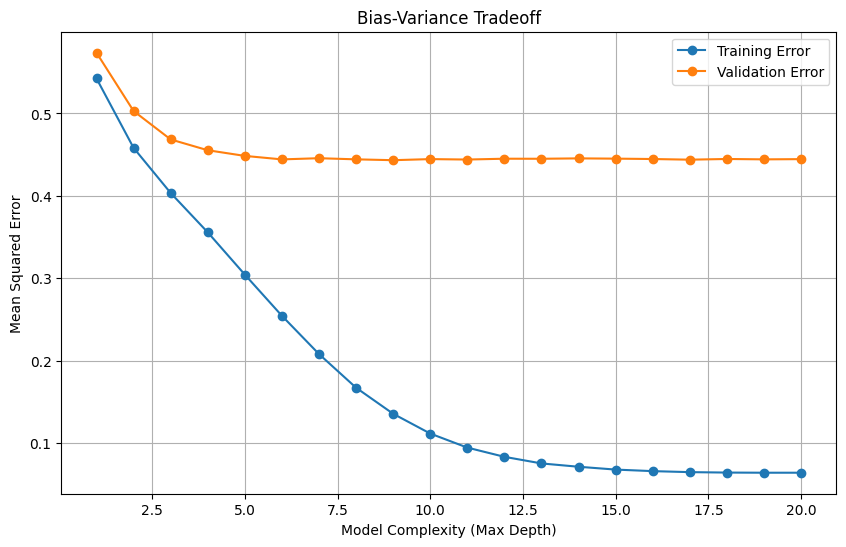

In [17]:
# Arrays to store the results
max_depths = range(1, 21)
train_errors = []
val_errors = []

# Evaluate the model for different max depths
for max_depth in max_depths:
    model = RandomForestRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Calculate training error
    train_pred = model.predict(X_train)
    train_error = np.mean((train_pred - y_train)**2)
    train_errors.append(train_error)

    # Calculate validation error using cross-validation
    val_error = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    val_errors.append(val_error)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', marker='o')
plt.plot(max_depths, val_errors, label='Validation Error', marker='o')
plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Linear Regression
r2_linear = r2_score(y_test, y_test_pred_linear)
mse_linear = mean_squared_error(y_test, y_test_pred_linear)

# Lasso Regression
r2_lasso = r2_score(y_test, y_test_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)

# Polynomial Regression
r2_poly = r2_score(y_test, y_test_pred_poly)
mse_poly = mean_squared_error(y_test, y_test_pred_poly)

# Random Forest Regression
r2_rf = r2_score(y_test, y_test_pred_rf)
mse_rf = mean_squared_error(y_test, y_test_pred_rf)

# Create a summary table
results = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso Regression", "Polynomial Regression", "Random Forest"],
    "R-squared": [r2_linear, r2_lasso, r2_poly, r2_rf],
    "Mean Squared Error": [mse_linear, mse_lasso, mse_poly, mse_rf]
})

print(results)


                   Model  R-squared  Mean Squared Error
0      Linear Regression   0.425234            0.308670
1       Lasso Regression   0.437173            0.302258
2  Polynomial Regression   0.359254            0.344104
3          Random Forest   0.415835            0.313717


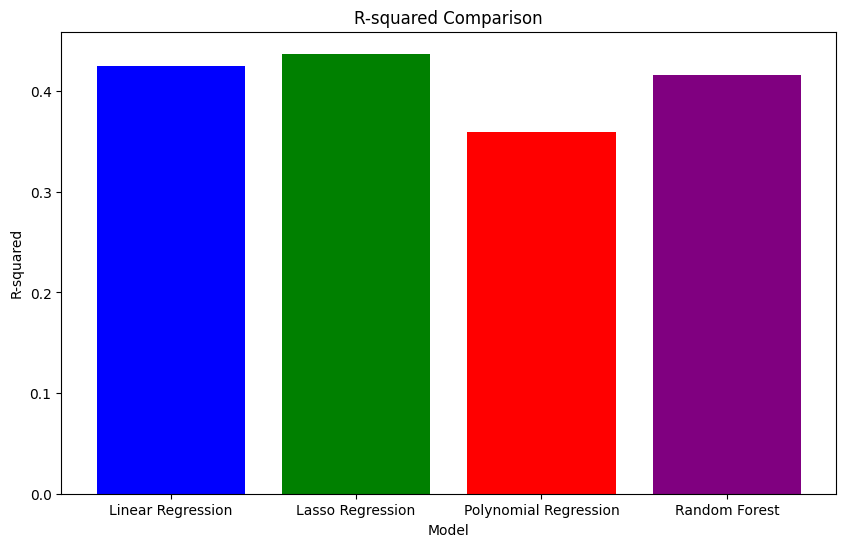

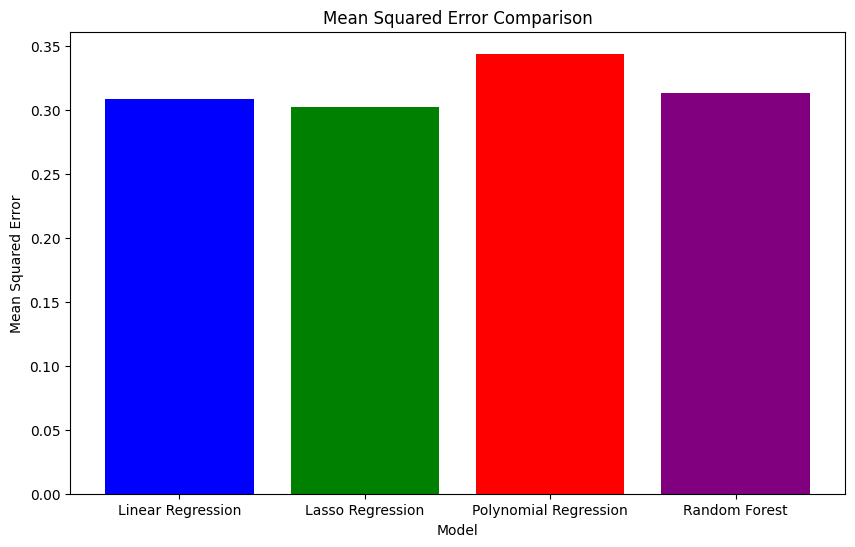

In [19]:
# Create a DataFrame with the results
results = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso Regression", "Polynomial Regression", "Random Forest"],
    "R-squared": [r2_linear, r2_lasso, r2_poly, r2_rf],
    "Mean Squared Error": [mse_linear, mse_lasso, mse_poly, mse_rf]
})

# Bar chart for R-squared
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['R-squared'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared Comparison')
plt.show()

# Bar chart for Mean Squared Error
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['Mean Squared Error'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error Comparison')
plt.show()


Residual analysis for Lasso regression

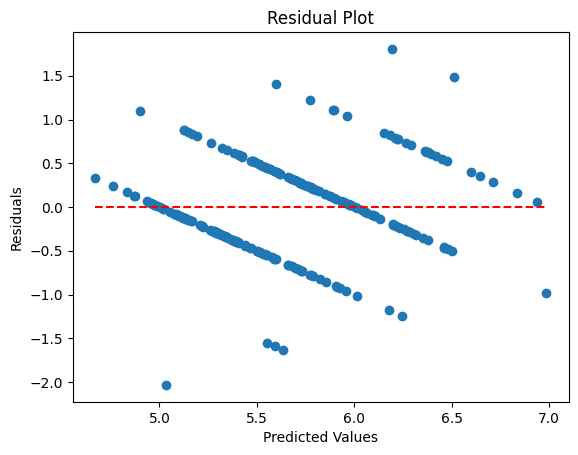

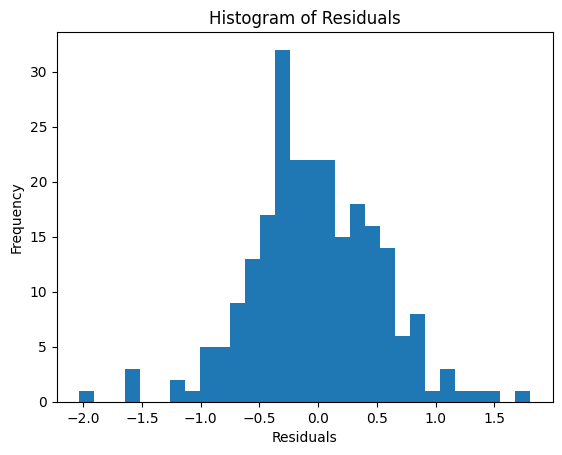

In [20]:
# Residuals
residuals = y_test - y_test_pred_lasso

# Plot residuals
plt.scatter(y_test_pred_lasso, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.hlines(y=0, xmin=min(y_test_pred_lasso), xmax=max(y_test_pred_lasso), colors='r', linestyles='dashed')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
